In [29]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d as p3
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

In [30]:
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,Id):
        
        self.dt = t[1]-t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.e= 0.1  #Epsilon
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        self.L = np.zeros(len(r0))
        
        self.m = m
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        self.AngularMomentumVector = np.zeros((len(t),len(v0)))
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        
        
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G = 4*np.pi**2        
        # Initial condition
        
        # Esto significa en el pasado
        
        self.rp = r0 #Aleatorio
        self.vp = v0 #Igual a cero 
        
        
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        self.SetAngularMomentum(i,self.r,self.m*self.v)
        
        
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        # Change variables using the verlet method
        
        self.a = self.Force/self.m
        
     
        if i == 0:
            
            self.rp = self.r
            self.r = self.rp + self.dt * self.v #Se inicializa con Euler. 
        
        else:
            
            self.rf = 2*self.r - self.rp + self.a * self.dt**2            
            self.v = ( self.rf - self.rp ) / (2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
        
  
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
    
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
        self.AngularMomentumVector[i] = self.L
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep

    
    # Getters
    
    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
        Fn = - self.G * self.m * p.m / ((d**2 + self.e**2)**(3./2.))
        
        self.Force = np.add( self.Force, Fn* (self.r - p.GetPosition()))
        
        self.Ep += - self.G * self.m * p.m / (d**2 + self.e**2)**(0.5)
                
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.AngularMomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        #return -np.dot( self.m*self.a, self.r )
        return 0.5*self.Ep 
   
    def GetNetForce(self):
        return self.Force

    def GetR(self):
        return self.radius
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [31]:
dt = 0.001
tmax = 2.
t = np.arange(0.,tmax,dt)

In [32]:
def GetParticles(NParticles,Limit,Dim=3):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform( -Limit, Limit, size=Dim )
        v0 = np.zeros(Dim)
        a0 = np.zeros(Dim)
        
        p = Particle(x0,v0,a0,t,0.01,i)
        
        Particles_.append(p)
        
    return Particles_

In [33]:
Limits = np.array([2.,2.,2.]) 

In [34]:
def RunSimulation(t,NParticles = 100):
    
    # Creating the particles
    Particles = GetParticles(NParticles,1.)
      
    for it in tqdm(range(len(t))):
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
                         
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
                     
    return Particles

In [35]:
Particles = RunSimulation(t)

100%|██████████| 2000/2000 [05:53<00:00,  5.65it/s]


In [36]:
EnergiaK = Particles[0].EkVector
EnergiaP = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK = np.add(EnergiaK, Particles[i].EkVector)
    EnergiaP = np.add(EnergiaP, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()
MomentumA = Particles[0].GetAngularMomentumVector()
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 
    MomentumA = np.add(MomentumA, Particles[i].GetAngularMomentumVector())

<IPython.core.display.Javascript object>


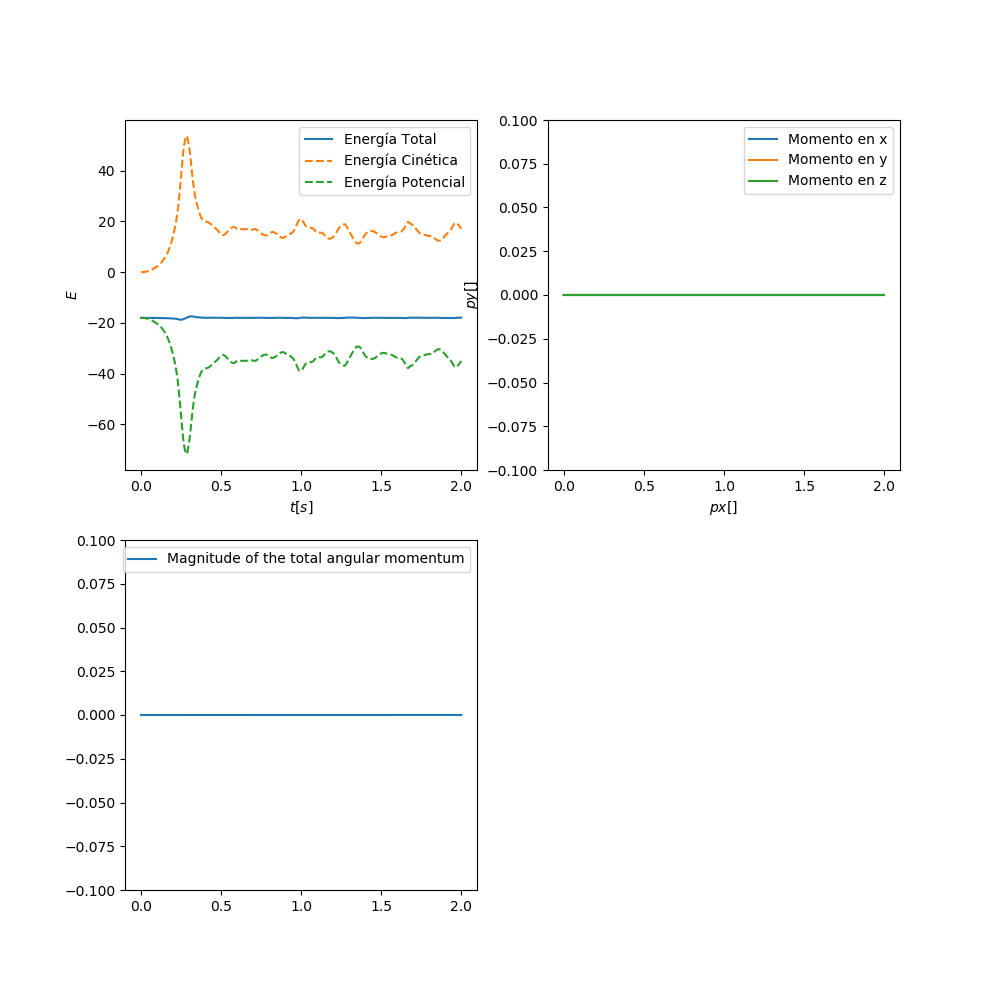

In [44]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)

ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=10)
ax1.set_ylabel(r'$E$',fontsize=10)
#ax1.set_yscale('log')
ax1.legend(loc=0)


ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], label='Momento en z')
ax2.set_xlabel(r'$px[]$',fontsize=10)
ax2.set_ylabel(r'$py[]$',fontsize=10)
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)

ax3.plot(t,MomentumA[:,0], label='Magnitude of the total angular momentum')
ax3.legend(loc=0)
ax3.set_ylim(-0.1,0.1)



plt.show()
plt.savefig("n-cuerpos_graficasE.png")

In [38]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [39]:
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


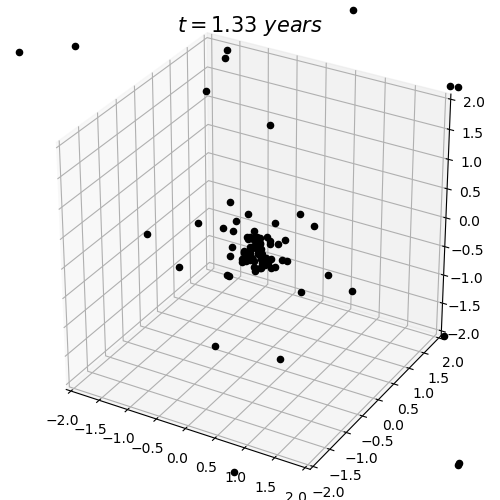

In [40]:
fig2 = plt.figure(figsize=(5,5))
ax = p3.Axes3D(fig2)

def init():
    ax.set_xlim3d(-Limits[0],Limits[0])
    ax.set_ylim3d(-Limits[1],Limits[1])
    ax.set_zlim3d(-Limits[2],Limits[2])
    
    
def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        plot=ax.scatter(x,y,z, c="k")
        
    return plot

Animation = anim.FuncAnimation(fig2,Update,frames=len(redt),init_func=init)

In [45]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=30, metadata=dict(artist='Me'))
Animation.save('N-cuerpos.mp4', writer=writer_)